In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.optimize as opt
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [15]:
# Load data 
df = pd.read_excel('Thesis_V6.xlsx')


In [16]:
# Replace NaN values with column means
df.fillna(df.mean(), inplace=True)

In [19]:
# Define sigmoid function
def sigmoid(x, A, B, C):
    return A / (1 + np.exp(-B * (x - C)))

# Define power law function
def power_law(x, a, b):
    return a * np.power(x, b)

In [17]:
# Define variables 
variables = {
    'Precipitation (mm/year)': df['Precipitation'].values,
    'Temperature Seasonality': df['Temp_seasonality'].values,
    'Precipitation Intensity Parameter a (mm/h)': df['a'].values,
    'Aridity': df['Aridity'].values 

y_data_full = df['Recharge fraction'].values

/var/folders/79/63bnf85s5bqggmz2_tltf7_m0000gn/T/ipykernel_35827/3074230355.py:3: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-B * (x - C)))
/var/folders/79/63bnf85s5bqggmz2_tltf7_m0000gn/T/ipykernel_35827/3074230355.py:3: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-B * (x - C)))
/var/folders/79/63bnf85s5bqggmz2_tltf7_m0000gn/T/ipykernel_35827/3074230355.py:7: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)
/var/folders/79/63bnf85s5bqggmz2_tltf7_m0000gn/T/ipykernel_35827/3074230355.py:3: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-B * (x - C)))


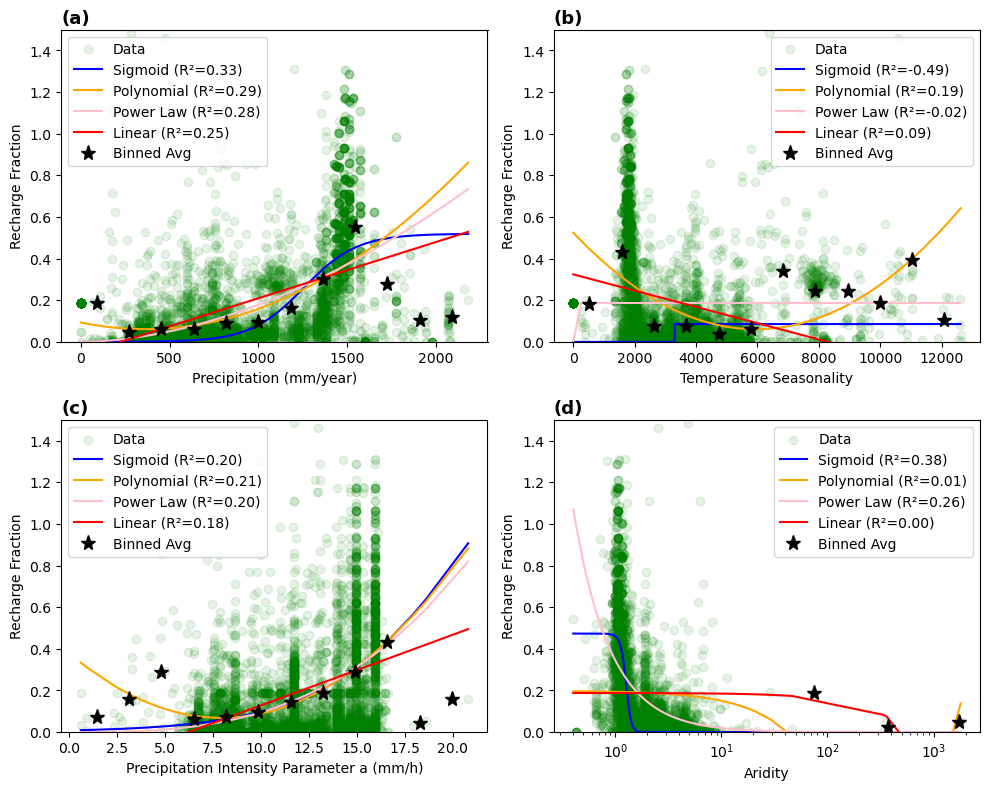

In [21]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Labels for subplot annotations
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

for i, (var_name, x_data_raw) in enumerate(variables.items()):
    y_data = y_data_full.copy()
    x_data = x_data_raw.copy()

    ax = axes[i]

    # Special handling for Aridity
    if var_name == 'Aridity':
        mask = x_data > 0  # Remove zero or negative values
        x_data = x_data[mask]
        y_data = y_data[mask]
    
    # Sort data for plotting
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data[sorted_indices]
    y_sorted = y_data[sorted_indices]
    

    # Sigmoid Model

    try:
        initial_params = [max(y_data), 1, np.median(x_data)]
        params, _ = opt.curve_fit(sigmoid, x_data, y_data, p0=initial_params, maxfev=10000)
        y_pred_sigmoid = sigmoid(x_sorted, *params)
        sigmoid_r2 = r2_score(y_data, sigmoid(x_data, *params))
    except:
        y_pred_sigmoid = np.full_like(x_sorted, np.nan)
        sigmoid_r2 = np.nan

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(x_data.reshape(-1, 1), y_data)
    y_pred_linear = linear_model.predict(x_sorted.reshape(-1, 1))
    linear_r2 = linear_model.score(x_data.reshape(-1, 1), y_data)
    
    

    # Power Law Model

    try:
        params, _ = curve_fit(power_law, x_data, y_data)
        y_pred_powerlaw = power_law(x_sorted, *params)
        powerlaw_r2 = r2_score(y_data, power_law(x_data, *params))
    except:
        y_pred_powerlaw = np.full_like(x_sorted, np.nan)
        powerlaw_r2 = np.nan
        
        

    # Polynomial Model (2nd degree)
    coeffs = np.polyfit(x_data, y_data, 2)
    poly_model = np.poly1d(coeffs)
    y_pred_poly = poly_model(x_sorted)
    poly_r2 = r2_score(y_data, poly_model(x_data))

    # Plot
    ax.scatter(x_data, y_data, label='Data', color='green', alpha=0.1)
    ax.plot(x_sorted, y_pred_sigmoid, label=f'Sigmoid (R²={sigmoid_r2:.2f})', color='blue')
    ax.plot(x_sorted, y_pred_poly, label=f'Polynomial (R²={poly_r2:.2f})', color='orange')
    ax.plot(x_sorted, y_pred_powerlaw, label=f'Power Law (R²={powerlaw_r2:.2f})', color='pink')
    ax.plot(x_sorted, y_pred_linear, color='red', label=f'Linear (R²={linear_r2:.2f})')

    #Plot binned average values 
    bin_means, bin_edges, _ = stats.binned_statistic(x_data, y_data, statistic='mean', bins=12)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    valid = ~np.isnan(bin_means)
    ax.plot(bin_centers[valid], bin_means[valid], 'k*', markersize=11, label='Binned Avg')
    
    
    # Axis labels and title
    ax.set_xlabel(var_name)
    ax.set_ylabel('Recharge Fraction')
    ax.set_ylim(0, 1.5)  # Set both lower and upper limits of y-axis

    if var_name == 'Aridity':
        ax.set_xscale('log')

    # Add subplot label (a), (b), etc.
    ax.annotate(subplot_labels[i],
                xy=(0, 1.02), xycoords='axes fraction',
                fontsize=13, fontweight='bold')

    ax.legend()

# Adjust layout and save
plt.tight_layout()
#plt.savefig("subplot_correlation_labeled_fixed.png", dpi=300, bbox_inches='tight')

plt.show()
